In [22]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
%matplotlib inline

In [2]:
ls

annie_recovery/               model1.h5
CarND-Behavioral-Cloning-P3/  model-weights1.h5
clone-personal.ipynb          Pipeline.ipynb
data/                         recover_laps_backwards_2/
data_ac/                      recovery_laps/
Data_ac_backwards_training/   recovery_laps_more/
Data_Acquisition_2/           training_data_g.p
data_acquisition.ipynb        training_data.p
data_acquisition_method.txt   tree.txt


#### Create Data Frame

In [3]:
def createDataFrame(data_path):
    """
    input: data_path: path to data
    return: data frame
    """
    data_frame = pd.read_csv(data_path)
    data_frame.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    return data_frame

#### Create Training Data

(array([ 851.,  735.,  575.,  385.,  224.,  124.,   63.,   30.,    9.,    4.]),
 array([  2.03776749e-04,   3.62267210e-01,   7.24330644e-01,
          1.08639408e+00,   1.44845751e+00,   1.81052094e+00,
          2.17258438e+00,   2.53464781e+00,   2.89671125e+00,
          3.25877468e+00,   3.62083811e+00]),
 <a list of 10 Patch objects>)

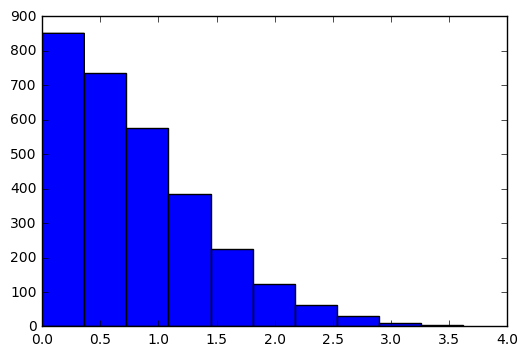

In [126]:
n = abs(abs(np.random.normal(size = 3000)))
plt.hist(n)

(array([ 20.,  24.,  18.,  12.,  16.,  24.,  23.,  16.,  28.,  19.]),
 array([ 0.01452806,  1.0121066 ,  2.00968513,  3.00726367,  4.0048422 ,
         5.00242074,  5.99999927,  6.99757781,  7.99515634,  8.99273488,
         9.99031341]),
 <a list of 10 Patch objects>)

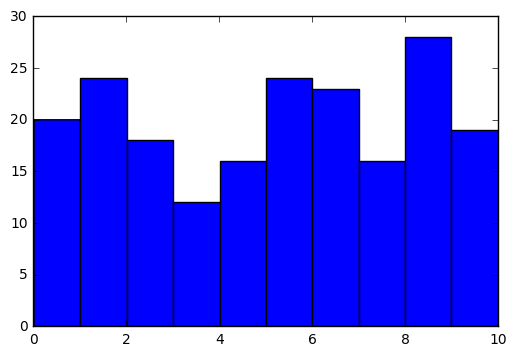

In [151]:
p = 0.001 * np.random.uniform()
pos_neg = np.random.uniform(size = 200) * 10
plt.hist(pos_neg)

In [211]:
a = np.random.uniform(-1, 1)/30.0
print('a: ', a)

a:  -0.028545203524582792


In [160]:
def appendWithProb(impath, images, meas, ang, threshold):
    perturb = 0.001 * np.random.uniform()
    if abs(ang) >= threshold:
        meas.append(ang)
        images.append(impath)
        n = abs(abs(np.random.normal()))
        if n < 1.5:
            pos_neg = np.random.uniform() * 10
            if 0 <= pos_neg <= 4.99999999:
                images.append(impath)
                meas.append(ang + (-1 * perturb))
            else:
                images.append(impath)
                meas.append(ang + (1 * perturb))
                
                

        
    elif abs(ang) < threshold:
        prob = abs(1 - abs(np.random.normal()))
        if prob < 1:
            meas.append(ang)
            images.append(impath)
    return (images, meas)

In [161]:
def createTrainingDataPathsCenterLeftRightPrefix(df, start, end, correction_factor, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    center_images = []
    left_images = []
    right_images = []
    measurements = []
    abs_path_to_IMG = os.path.abspath(prefix_path)
    for idx, row in df.iterrows():
        if start <= idx <= end:
            # center images
            image_path = os.path.join(abs_path_to_IMG, row['center'].strip())
            angle = row['steering']            
            center_images, measurements = appendWithProb(image_path, center_images, measurements, angle, 0.149)
           
            # left images
            left_images.append(os.path.join(abs_path_to_IMG, row['left'].strip()))
            measurements.append(row['steering'] + correction_factor)
            
            # right images
            right_images.append(os.path.join(abs_path_to_IMG, row['right'].strip()))
            measurements.append(row['steering'] - correction_factor)
            
    return (np.asarray(center_images), np.asarray(left_images), np.asarray(right_images), np.asarray(measurements, dtype=np.float32))

In [5]:
def createTrainingDataPathsCenterLeftRight(df, start, end, correction_factor):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    center_images = []
    left_images = []
    right_images = []
    measurements = []
    for idx, row in df.iterrows():
        if start <= idx <= end:
            # center images
            center_images.append(row['center'].strip())
            measurements.append(row['steering'])
            
            # left images
            left_images.append(row['left'].strip())
            measurements.append(row['steering'] + correction_factor)
            
            # right images
            right_images.append(row['right'].strip())
            measurements.append(row['steering'] - correction_factor)
            
    return (np.asarray(center_images), np.asarray(left_images), np.asarray(right_images), np.asarray(measurements, dtype=np.float32))

In [187]:
def createTrainingDataCenterOnly(df, start, end):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    images = []
    measurements = []
    
    for idx, row in df.iterrows():
        if start <= idx <= end:
            # center images
            images.append(row['center'].strip())
            measurements.append(row['steering'])
    return (np.asarray(images), np.asarray(measurements, dtype=np.float32))

In [188]:
def createTrainingDataCenterOnlyFromPrefix(df, start, end, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    start: starting row to grab data
    end: ending row to grab data
    correction_factor: factor to correct steering angles
    """
    images = []
    measurements = []
    abs_path_to_IMG = os.path.abspath(prefix_path)
    print('abs_path_to_IMG: ', abs_path_to_IMG)
    
    for idx, row in df.iterrows():
        if start <= idx <= end:
            # center images
            images.append(os.path.join(abs_path_to_IMG, row['center'].strip()))
            measurements.append(row['steering'])
    return (np.asarray(images), np.asarray(measurements, dtype=np.float32))

#### Create data from /data_ac_backwards_training (cw)

In [189]:
data_pd_cw1 = createDataFrame('Data_ac_backwards_training/driving_log.csv')
X_train_cw1_c, X_train_cw1_l, X_train_cw1_r, y_train_cw1 = createTrainingDataPathsCenterLeftRight(data_pd_cw1, 1164, 3941, 0.25)
print('length X_train_cw1: ', len(X_train_cw1_c))
print('length y_train_cw1: ', len(y_train_cw1))

length X_train_cw1:  2778
length y_train_cw1:  8334


In [222]:
# plt.hist(y_train_cw1,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

#### Create data from /data_ac (ccw)

In [191]:
data_pd_ccw1 = createDataFrame('data_ac/driving_log.csv')
X_train_ccw1_c, X_train_ccw1_l, X_train_ccw1_r, y_train_ccw1 = createTrainingDataPathsCenterLeftRight(data_pd_ccw1, 2000, 4777, 0.25)
print('length X_train_ccw1: ', len(X_train_ccw1_c))
print('length y_train_ccw1: ', len(y_train_ccw1))

length X_train_ccw1:  2778
length y_train_ccw1:  8334


In [213]:
# plt.hist(y_train_ccw1,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

#### Create data from /recovery_laps_more (ccw)

In [193]:
data_pd_ccwr1 = createDataFrame('recovery_laps_more/driving_log.csv')
X_train_ccwr1_c, X_train_ccwr1_l, X_train_ccwr1_r, y_train_ccwr1 = createTrainingDataPathsCenterLeftRight(data_pd_ccwr1, 50, 358, 0.25)
print('length of X_train_ccwr1: ', len(X_train_ccwr1_c))
print('length of y_train_ccwr1: ', len(y_train_ccwr1))

length of X_train_ccwr1:  307
length of y_train_ccwr1:  921


In [214]:
# plt.hist(y_train_ccwr1,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

#### Create data from /recovery_laps (ccw)

In [195]:
data_pd_ccwr2 = createDataFrame('recovery_laps/driving_log.csv')
X_train_ccwr2_c, X_train_ccwr2_l, X_train_ccwr2_r, y_train_ccwr2 = createTrainingDataPathsCenterLeftRight(data_pd_ccwr2, 20, 930, 0.25)
print('length of X_train_ccwr2: ', len(X_train_ccwr2_c))
print('length of y_train_ccwr2: ', len(y_train_ccwr2))

length of X_train_ccwr2:  911
length of y_train_ccwr2:  2733


In [215]:
# plt.hist(y_train_ccwr2,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

#### Create data from /recovery_laps_backwards_2(cw)

In [216]:
data_pd_cwr1 = createDataFrame('recover_laps_backwards_2/driving_log.csv')
X_train_cwr1_c, X_train_cwr1_l, X_train_cwr1_r, y_train_cwr1 = createTrainingDataPathsCenterLeftRight(data_pd_cwr1, 9, 694, 0.25)
print('length of X_train_cwr1: ', len(X_train_cwr1_c))
print('length of y_train_cwr1: ', len(y_train_cwr1))
# data_pd_cwr1.hist(column = 'steering')

length of X_train_cwr1:  684
length of y_train_cwr1:  2052


In [217]:
# plt.hist(y_train_cwr1,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

#### Create data from /annie_recovery (cw)

In [218]:
data_pd_cwr2 = createDataFrame('annie_recovery/driving_log_recovery.csv')
# data_pd_cwr2.hist(column = 'steering')
# data_pd_cwr2.hist(column = 'steering',bins=100,range=(-1,1),facecolor="r", histtype = 'step')

In [219]:
X_train_cwr2_c, X_train_cwr2_l, X_train_cwr2_r, y_train_cwr2 = createTrainingDataPathsCenterLeftRightPrefix(data_pd_cwr2, 1, 1348, 0.25, 'annie_recovery/')
print('length of X_train_cwr2: ', len(X_train_cwr2_c))
print('length of y_train_cwr2: ', len(y_train_cwr2))
# plt.hist(y_train_cwr2,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

length of X_train_cwr2:  1834
length of y_train_cwr2:  4526


#### Create data from /data (udacity) (cw)

In [220]:
data_pd_cw2 = createDataFrame('data/driving_log.csv')
X_train_cw2_c, X_train_cw2_l, X_train_cw2_r, y_train_cw2 = createTrainingDataPathsCenterLeftRightPrefix(data_pd_cw2, 50, 8036,0.25, 'data/')
print('length of X_train_cw2: ', len(X_train_cw2_c))
print('length of y_train_cw2: ', len(y_train_cw2))
# data_pd_cw2.hist(column = 'steering')

length of X_train_cw2:  8992
length of y_train_cw2:  24964


In [221]:
# plt.hist(y_train_cw2,bins=100,range=(-1,1),facecolor="r", histtype = 'step')

#### Convert to numpy arrays

In [241]:
# Data from X_train_cw1
X_train = np.append(X_train_cw1_c, X_train_cw1_l, axis = 0)
X_train = np.append(X_train, X_train_cw1_r, axis = 0)

y_train = y_train_cw1
assert(X_train.shape[0] == y_train.shape[0])

# Data from X_train_ccwr1
X_train = np.append(X_train, X_train_ccwr1_c, axis = 0)
X_train = np.append(X_train, X_train_ccwr1_l, axis = 0)
X_train = np.append(X_train, X_train_ccwr1_r, axis = 0)

y_train = np.append(y_train, y_train_ccwr1, axis = 0)
assert(X_train.shape[0] == y_train.shape[0])

# Data from CCWR2:
X_train = np.append(X_train, X_train_ccwr2_c, axis = 0)
X_train = np.append(X_train, X_train_ccwr2_l, axis = 0)
X_train = np.append(X_train, X_train_ccwr2_r, axis = 0)

y_train = np.append(y_train, y_train_ccwr2, axis = 0)
assert(X_train.shape[0] == y_train.shape[0])

# Data from CWR1
X_train = np.append(X_train, X_train_cwr1_c, axis = 0)
X_train = np.append(X_train, X_train_cwr1_l, axis = 0)
X_train = np.append(X_train, X_train_cwr1_r, axis = 0)

y_train = np.append(y_train, y_train_cwr1, axis = 0)
assert(X_train.shape[0] == y_train.shape[0])

# Data from CWR2:
X_train = np.append(X_train, X_train_cwr2_c, axis = 0)
X_train = np.append(X_train, X_train_cwr2_l, axis = 0)
X_train = np.append(X_train, X_train_cwr2_r, axis = 0)

y_train = np.append(y_train, y_train_cwr2, axis = 0)
assert(X_train.shape[0] == y_train.shape[0])

# Data from CW2:
X_train = np.append(X_train, X_train_cw2_c, axis = 0)
X_train = np.append(X_train, X_train_cw2_l, axis = 0)
X_train = np.append(X_train, X_train_cw2_r, axis = 0)

y_train = np.append(y_train, y_train_cw2, axis = 0)
assert(X_train.shape[0] == y_train.shape[0])

print('X_train general shape: ', X_train.shape)
print('y_train general shape: ', y_train.shape)

X_train general shape:  (43530,)
y_train general shape:  (43530,)


In [242]:
# # Udacity + Recovery data only - images
# # Data from CWR2:
# X_train = np.append(X_train_cwr2_c, X_train_cwr2_l, axis = 0)
# X_train = np.append(X_train, X_train_cwr2_r, axis = 0)


# # Data from CW2:
# X_train = np.append(X_train, X_train_cw2_c, axis = 0)
# X_train = np.append(X_train, X_train_cw2_l, axis = 0)
# X_train = np.append(X_train, X_train_cw2_r, axis = 0)

# y_train = np.append(y_train_cwr2, y_train_cw2, axis = 0)
# assert(X_train.shape[0] == y_train.shape[0])

In [243]:
print('X_train udacity: ', X_train.shape)
print('y_train udacity: ', y_train.shape)

X_train udacity:  (43530,)
y_train udacity:  (43530,)


#### Save training data to pickle file

In [244]:
training_data = {
    'image': X_train,
    'steer': y_train
    }
with open('training_data_refactor.p', 'wb') as handle:
    pickle.dump(training_data, handle, protocol=pickle.HIGHEST_PROTOCOL)